In [8]:
from PIL import Image
import numpy as np

In [9]:
print("hi")

hi


# 'topOpter' - must run :)

In [85]:

import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

from scipy.optimize import Bounds,LinearConstraint,NonlinearConstraint
from scipy.optimize import minimize

def OptimalityFunction_mass(x):
            #    #return the current mass of the object as the sum of all the elements
  return abs(x.sum())
def OptimalityJacobian_mass(x):
                # since the sum of all the elements is linear with respect to each element the derivative of the mass with respect to each element is one
                # thus the optimality jacobian is an array of ones.
  return np.ones(len(x))

class topOpter:
    def __init__(self,nelx,nely,volfrac,penal,rmin,ft):
        self.nelx =nelx
        self.nely = nely
        self.volfrac = volfrac
        self.penal = penal
        self.rmin = rmin
        self.ft = ft
        self.massPenaltyFactor = 0
        self.complianceMax = 5
        self.minChange = 0.01
        self.maxElementChange = .1

        #added by Isaac and interacts with the 'if' statment in function 'itterate'
        self.targetvolume = nelx * nely * volfrac
        

        print("Minimum compliance problem with OC")
        print("ndes: " + str(nelx) + " x " + str(nely))
        print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
        print("Filter method: " + ["Sensitivity based","Density based"][ft])
        
        # Max and min stiffness
        self.Emin=1e-9
        self.Emax=1.0
        # dofs:
        self.ndof = 2*(nelx+1)*(nely+1)

        # Allocate design variables (as array), initialize and allocate sens.
        self.x=np.ones(nely*nelx,dtype=float)
        self.xold=self.x.copy()
        self.xPhys=self.x.copy()

        self.g=0 # must be initialized to use the NGuyen/Paulino OC approach
        self.dc=np.zeros((nely,nelx), dtype=float)

        # FE: Build the index vectors for the for coo matrix format.
        self.KE=self.lk()
        self.edofMat=np.zeros((nelx*nely,8),dtype=int)
        for elx in range(nelx):
            for ely in range(nely):
                el = ely+elx*nely
                n1=(nely+1)*elx+ely
                n2=(nely+1)*(elx+1)+ely
                self.edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

        # Construct the index pointers for the coo format
        self.iK = np.kron(self.edofMat,np.ones((8,1))).flatten()
        self.jK = np.kron(self.edofMat,np.ones((1,8))).flatten()    

        # Filter: Build (and assemble) the index+data vectors for the coo matrix format
        nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
        self.iH = np.zeros(nfilter)
        self.jH = np.zeros(nfilter)
        self.sH = np.zeros(nfilter)
        cc=0
        for i in range(nelx):
            for j in range(nely):
                row=i*nely+j
                kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
                kk2=int(np.minimum(i+np.ceil(rmin),nelx))
                ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
                ll2=int(np.minimum(j+np.ceil(rmin),nely))
                for k in range(kk1,kk2):
                    for l in range(ll1,ll2):
                        col=k*nely+l
                        fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                        self.iH[cc]=row
                        self.jH[cc]=col
                        self.sH[cc]=np.maximum(0.0,fac)
                        cc=cc+1
        # Finalize assembly and convert to csc format
        self.H=coo_matrix((self.sH,(self.iH,self.jH)),shape=(nelx*nely,nelx*nely)).tocsc()    
        self.Hs=self.H.sum(1)
        def IX(x,y):
            return y*nely + x
        # BC's and support
        dofs=np.arange(2*(nelx+1)*(nely+1))
        #fixed=np.union1d(dofs[0:2*(5):2],np.array([2*(nelx+1)*(nely+1)-1]))
        #fixed = np.array([0,1,3,4])
        fixed = dofs[0:2*(nely-1):1]
        self.free=np.setdiff1d(dofs,fixed)
        self.numberOfFixedPoints = len(fixed)

        # Solution and RHS vectors
        # for n number of forces each of these must be and n-dimesional column vector
        self.numberOfForces = 2
        self.f=np.zeros((self.ndof,self.numberOfForces))
        self.u=np.zeros((self.ndof,self.numberOfForces))

        # Set load
        #self.f[0,0] = -1

        

    

        #passive elements
        self.passive = np.zeros((nely) * (nelx))


        # Set loop counter and gradient vectors 
        self.loop=0
        self.change=1
        self.objective_mass = self.targetvolume #0 #edited by isaac, used to be '0'
        self.constraint_compliance = 0
        self.dv = np.ones(nely*nelx)
        self.dc = np.ones(nely*nelx)
        self.ce = np.ones(nely*nelx)

    @jit(target_backend='cuda')	
    def itterate(self):
        #Check if the current setup has all the minimum requirements for optimization.
        canCompute = (self.numberOfForces > 0) and (self.numberOfFixedPoints > 3 )

        
        # targetvolume and change to the 'if' statement by isaac; goal is to stop iterating once we reach desired mass
        # do not run the optimization step if any of the following conditions are false
        if( (self.change>self.minChange and self.loop<500 and canCompute) ): #and (self.objective_mass >= self.targetvolume) ):
            self.loop += 1

            # Optimality criteria
            self.xold[:]=self.x


                # MOVED ELSEWHERE BY ISAAC
            #optimality function: reduce mass
            #def OptimalityFunction_mass(x):
            #    #return the current mass of the object as the sum of all the elements
            #    return abs(x.sum())
            #def OptimalityJacobian_mass(x):
                # since the sum of all the elements is linear with respect to each element the derivative of the mass with respect to each element is one
                # thus the optimality jacobian is an array of ones.
            #    return np.ones(len(x))

            #Constraints for the function
            g1_compliance = self.getNonlinearConstraint_comliance()

            self.x[:]= self.optimality_criterion(OptimalityFunction_mass, OptimalityJacobian_mass, [g1_compliance], self.maxElementChange)

            # Filter design variables
            self.xPhys[:]=self.x

            #filter the part based on density
            #self.xPhys[:]=np.asarray(self.H*self.x[np.newaxis].T/self.Hs)[:,0]
            
            # Compute the change by the inf. norm or the max element change in the part.
            self.change=np.linalg.norm(self.x.reshape(self.nelx*self.nely,1)-self.xold.reshape(self.nelx*self.nely,1),np.inf)


            # Compute the new mass and compliance to be printed out
            self.objective_mass = self.xPhys.sum()
            self.constraint_compliance = self.Compliance(self.xPhys)
            # Write iteration history to screen (req. Python 2.6 or newer)
            print("it.: {0} , Compliance.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(self.loop,self.constraint_compliance,self.objective_mass,self.change))
            
            #ADDED BY ISAAC TO TRY AND FIX :( it won't stop even after target mass is reached
            if self.objective_mass <= self.targetvolume:
              print("OOGA BOOGA")
              return False
            
            return True
        else:
            return False

    def getNonlinearConstraint_comliance(self):
        """
        Returns a scipy NonlinearConstrain built using the compliance function
        boundaries are 0 <= current_compliance <= compliance_max
        """

        #constraint of compliance function
        def constraint_g1(x):
            return self.Compliance(x)
        #jacobian of compliance function
        def consstraint_g1_Jacobian(x):
            return self.Jacobian_Compliance(x)

        lowerBound = 0 # the compliance of any object cannot be zero so this is a good lower bound
        upperBound = self.complianceMax #constrains the compliance to be under the max allowable compliance

        nonlinear_constraint = NonlinearConstraint(constraint_g1,lowerBound,upperBound,jac=consstraint_g1_Jacobian)
        return nonlinear_constraint

    def sensitivityAnalysis(self,x):
        # Setup and solve FE problem
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(x)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()

        # Remove constrained dofs from matrix
        K = K[self.free,:][:,self.free]

        # Solve system 
        u=np.zeros((self.ndof,self.numberOfForces+1))
        f=self.f[self.free,:]
        sps = spsolve(K,f)
        u[self.free,:] = sps
         
        ce = np.ones(self.nely*self.nelx)
        dc = np.zeros(self.nely*self.nelx)
        compliance = 0
        for i in range(self.numberOfForces):
            Ui = u[:,i]
            ce = (np.dot(Ui[self.edofMat].reshape(self.nelx*self.nely,8),self.KE) * Ui[self.edofMat].reshape(self.nelx*self.nely,8) ).sum(1)
            compliance += ((self.Emin+x**self.penal*(self.Emax-self.Emin))*ce).sum()
            if(i == 0):
                dc[:]=(-self.penal*x**(self.penal-1)*(self.Emax-self.Emin))*ce
            else:
                dc[:]= dc[:] + (-self.penal*x**(self.penal-1)*(self.Emax-self.Emin))*ce

        # Sensitivity filtering:
        self.dc[:] = np.asarray((self.H*(self.x*self.dc))[np.newaxis].T/self.Hs)[:,0] / np.maximum(0.001,self.x)
        
        return compliance,dc

    def Compliance(self,x):
        """
        Takes in a numpy array representing the elements in the current part
        returns the current compliance of the part given the predefined load vectors and free/fixed elements

        Work for the function is done in the senstvity analysis but only the compliance is passed outside the function
        """
        return self.sensitivityAnalysis(x)[0]

    def Jacobian_Compliance(self,x):
        """
        Takes in a numpy array representing the elements in the current part
        returns the jacobian of the complinace function as a numpy array where each index coresponds to the gradient of the compliance function with resepect to that index of x
        
        Work for the function is done in the senstvity analysis but only the derivative of the compliance is passed outside the function
        """
        return self.sensitivityAnalysis(x)[1]

    def getPart(self):
        return self.xPhys.reshape((self.nelx,self.nely))
    
    def getDerivetiveOfSensitivity(self):
        return self.dc.reshape((self.nelx,self.nely))

    def clearPart(self):
        self.x=np.ones(self.nely*self.nelx,dtype=float)
        self.xold=self.x.copy()
        self.xPhys=self.x.copy()
        self.change = 1 
        self.loop = 0
        self.dv = np.ones(self.nely*self.nelx)
        self.dc = np.ones(self.nely*self.nelx)
        self.ce = np.ones(self.nely*self.nelx)
        self.g=0

    def getMassWithPenalty(self,penalty):
        if(penalty == 0):
            return self.xPhys.sum()
        else:
            mass = (self.xPhys + penalty*self.xPhys*(1 - self.xPhys)).sum()
            return mass

    #element stiffness matrix
    def lk(self):
        E=1
        nu=0.3
        k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
        KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
        [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
        [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
        [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
        [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
        [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
        [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
        [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ])
        return (KE)

    # Optimality criterion
    def optimality_criterion(self,OptimalityFunction,OptimalityJacobian,constraints,move):
        """
        This function is the brawn of the program
        Uses the scipy.optimize.minmize function

        The function takes:
        - the optimality function for mass (sum of all elements)
        - the jacobian of the optimality function (array of 1's since the mass scales linearly)
        - an array containing the linear and nonlinear constraints

        - the allowable change for each element from it's previous value


        The function returns:
            xNew as the new updated values of x

        """
        #create a new copy of our elements so as to not acidentaly edit them while otimizing
        xnew=self.xPhys.copy()
        
        #define bouds of x to be within move distance
        x_lowerBound = np.maximum(0,xnew - move*np.ones(len(xnew)))
        x_upperBound = np.minimum(1,xnew + move*np.ones(len(xnew)))
        bounds  = Bounds(x_lowerBound,x_upperBound)

        #create the minimization problem
        res = minimize(OptimalityFunction, xnew, method='SLSQP', jac=OptimalityJacobian,
               constraints=constraints,
               bounds=bounds)

        if(not res.success):
            self.printResults(res)

        xnew = res.x

        #do the passives
        xnew = np.where(self.passive == 1, 0, xnew)
        xnew = np.where(self.passive == 2, 1, xnew)
            
        return xnew

    def updatePassives(self,passiveArray):
        """
        the passive array is a nelx by nely 2D array with either 0,1,2 denoting free, force empty, or force fill

        the self.passive array is 1D of size nelx * nely with the same constraints
        """

        for x in range(self.nelx):
            for y in range(self.nely):
                self.passive[x*self.nely + y] = passiveArray[x][y]
        
        self.change = 1 
        self.loop = 0

    def updateLoads(self,loads):

        self.passive = np.zeros((self.nely) * (self.nelx))
        def IX(x,y):
            y*self.nely + x

        for i in range(self.nelx):
            for j in range(self.nely):
                if np.sqrt((j-loads[0][0])**2+(i-loads[0][1])**2) < loads[0][2]:
                    self.passive[IX(i,j)] = 1
                if np.sqrt((j-loads[1][0])**2+(i-loads[0][1])**2) < loads[0][2]:
                    self.passive[IX(i,j)] = 1
                if np.sqrt((j-loads[2][0])**2+(i-loads[0][1])**2) < loads[0][2]:
                    self.passive[IX(i,j)] = 1
        
    def updateFixed(self,fixedArray):
        """
        the fixedArray is a nelx by nely 2D array with either 0,1,2,3 denoting free, fixed horizontal, fixed vertical, or fixed both
        the self.fixed array is 1D of size 2*(nelx+1) * (nely+1)

        required:
            method to transloat element number into its 4 corners
                - in a 4x3 part input 0 should return 0,1,2,3,8,9,10,11
                - in a 4x3 part input 7 should return 18,19,20,21,26,27,28,29
            method to translate the 4 corners into their x and y components
                - horizontal is even 
                - vertical is odd
        """
        def getCorners(x,y):
            elementNum = (self.nely+1)*x + y
            cornerTL = [2*elementNum,2*elementNum+1]
            cornerBL = [2*elementNum+2,2*elementNum+3]
            element1over = (self.nely+1)*(x+1) + y
            cornerTR = [2*element1over,2*element1over+1]
            cornerBR = [2*element1over+2,2*element1over+3]

            return cornerTL,cornerTR,cornerBL,cornerBR

        
        dofs=np.arange(2*(self.nelx+1)*(self.nely+1))
        fixed = []


        for x in range(self.nelx):
            for y in range(self.nely):
                cornerTL,cornerTR,cornerBL,cornerBR = getCorners(x,y)
                if(fixedArray[x][y] == 1):
                    fixed.append(cornerTL[0])
                    fixed.append(cornerBL[0])
                    fixed.append(cornerTR[0])
                    fixed.append(cornerBR[0])
                elif(fixedArray[x][y] == 2):
                    fixed.append(cornerTL[1])
                    fixed.append(cornerBL[1])
                    fixed.append(cornerTR[1])
                    fixed.append(cornerBR[1])
                elif(fixedArray[x][y] == 3):
                    fixed.append(cornerTL[0])
                    fixed.append(cornerBL[0])
                    fixed.append(cornerTR[0])
                    fixed.append(cornerBR[0])
                    fixed.append(cornerTL[1])
                    fixed.append(cornerBL[1])
                    fixed.append(cornerTR[1])
                    fixed.append(cornerBR[1])

        self.numberOfFixedPoints = len(fixed)
        if(self.numberOfFixedPoints > 0):
            self.free=np.setdiff1d(dofs,np.array(fixed))
        else:
            self.free = dofs
        

        self.change = 1 
        self.loop = 0

    def updateForceVectors(self,vectorArray):
        def getCorners(x,y):
            elementNum = (self.nely+1)*x + y
            cornerTL = [2*elementNum,2*elementNum+1]

            return cornerTL

        forces =[]
        for x,y,vx,vy in vectorArray:
            if(vx == 0):
                #force in y direction
                cornerTL = getCorners(x,y)
                force = vy/4
                forces.append([cornerTL[1],force])
            elif(vy == 0):
                #force in x direction
                cornerTL = getCorners(x,y)
                force = vx/4
                forces.append([cornerTL[0],force])
        
        self.numberOfForces = len(forces)
        if(self.numberOfForces > 1):
            self.f=np.zeros((self.ndof,self.numberOfForces))
            self.u=np.zeros((self.ndof,self.numberOfForces))
        if(self.numberOfForces == 1):
            self.f=np.zeros((self.ndof,2))
            self.u=np.zeros((self.ndof,2))

        for i,vec in enumerate(forces):
            elementNumber = vec[0]
            force = vec[1]
            self.f[elementNumber,i] = force


        self.change = 1 
        self.loop = 0

    def showAnchors(self):
        print("Anchors")
        fixed = np.zeros(self.ndof)
        fixed[self.free] = 1
        self.drawPlots(fixed)
    
    def showForces(self):
        print("forceVectors")

        for i in range(self.numberOfForces):
            print("force:",i)
            self.drawPlots(self.f[:,i])

    def drawPlots(self,arr):
        print("arr1.shape = {}".format(arr.shape))
        l = max(arr.shape)//2

    def printResults(self,res):
        if(len(res.x) < 5):
            print("Optimal x values:",res.x)
        print("Success:",res.success)
        print("Status:",res.status)
        print("Message:",res.message)

#MatPlotlib

In [86]:
# A 165 LINE TOPOLOGY OPTIMIZATION CODE BY NIELS AAGE AND VILLADS EGEDE JOHANSEN, JANUARY 2013
import numpy as np

from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

#from topopt_scipyMinimize import topOpter

from time import time
import sys


def updateImageDropOff(imageArray,val):
    #remap image from [-1,0] to some other range
    rec = val/(val+1)
    #v = rec*np.ones(imageArray.shape)
    above0 = np.where(imageArray > val,0,(imageArray/(val+1)) - rec)

    return above0


def cantileverSetup(topopter :topOpter):
    """
    Setup the optimization enviroment for the cantilever beam.
    This is a bar that is anchored on the left side and has a force applied to it on the far left side
    Because this function changes variables within an object there is no need to return anything
    """
    nelx = topopter.nelx
    nely = topopter.nely
    anchorArray = np.zeros((nelx,nely))
    #fully anchor the far left side
    for y in range(nely):
        anchorArray[0,y] = 3
    topopter.updateFixed(anchorArray)

    # apply a force to the far richt side at the center
    topopter.updateForceVectors([[nelx-1,nely//2,0,1]])

**Testing these Parameters:**

In [87]:
n_el_x = 100
n_el_y = 50
vol_frac = 0.5
r_min = 0.5
p_enal = 0.5
f_t = 1

Minimum compliance problem with OC
ndes: 20 x 10
volfrac: 0.2, rmin: 5.4, penal: 3.0
Filter method: Sensitivity based
it.: 1 , Compliance.: 2.479 Vol.: 180.000, ch.: 0.100
it.: 2 , Compliance.: 3.530 Vol.: 160.000, ch.: 0.100
it.: 3 , Compliance.: 5.269 Vol.: 140.000, ch.: 0.100
it.: 4 , Compliance.: 8.367 Vol.: 120.000, ch.: 0.100
it.: 5 , Compliance.: 10.000 Vol.: 103.039, ch.: 0.100
it.: 6 , Compliance.: 10.000 Vol.: 91.532, ch.: 0.100
it.: 7 , Compliance.: 10.000 Vol.: 82.232, ch.: 0.100
it.: 8 , Compliance.: 10.000 Vol.: 72.440, ch.: 0.100
it.: 9 , Compliance.: 10.000 Vol.: 60.623, ch.: 0.100
it.: 10 , Compliance.: 10.000 Vol.: 47.002, ch.: 0.100
it.: 11 , Compliance.: 10.000 Vol.: 46.170, ch.: 0.100
it.: 12 , Compliance.: 10.000 Vol.: 45.831, ch.: 0.100
Success: False
Status: 8
Message: Positive directional derivative for linesearch
it.: 13 , Compliance.: 10.000 Vol.: 45.321, ch.: 0.100
it.: 14 , Compliance.: 10.000 Vol.: 44.944, ch.: 0.100
it.: 15 , Compliance.: 10.000 Vol.: 44.

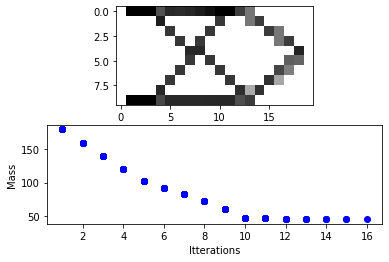

In [89]:
# The real main driver    
#@jit(target_backend='cuda')	
def driver (nelx, nely, volfrac, rmin, penal, ft):
    # Default input parameters
    #nelx= 20
    #nely= 10
    #volfrac=0.9
    #rmin=5.4
    #penal=3.0
    #ft=0 # ft==0 -> sens, ft==1 -> dens
    # The variables are in order: x position of cylinder, y position of cylinder, radius of the cylinder, the magnitude of the force,
    # and the counterclockwise angle of the force in degrees.
    circle_1 = [10,20,5,4,63]
    circle_2 = [15,20,7,5,115]
    circle_3 = [20,30,3,6,275]

    loads = [circle_1,circle_2,circle_3]

                              # This change was made by Isaac as a test
    if sys.argv[1] != '-f': 
      if len(sys.argv)>1: nelx   = int(sys.argv[1])
      if len(sys.argv)>2: nely   = int(sys.argv[2])
      if len(sys.argv)>3: volfrac= float(sys.argv[3])
      if len(sys.argv)>4: rmin   = float(sys.argv[4])
      if len(sys.argv)>5: penal  = float(sys.argv[5])
      if len(sys.argv)>6: ft     = int(sys.argv[6])

    #if len(sys.argv)>1: nelx   = n_el_x #int(sys.argv[1])
    #if len(sys.argv)>2: nely   = n_el_y #int(sys.argv[2])
    #if len(sys.argv)>3: volfrac= vol_frac #float(sys.argv[3])
    #if len(sys.argv)>4: rmin   = r_min #float(sys.argv[4])
    #if len(sys.argv)>5: penal  = p_enal #float(sys.argv[5])
    #if len(sys.argv)>6: ft     = f_t #int(sys.argv[6])
    #print(loads)



    t = topOpter(nelx,nely,volfrac,penal,rmin,ft)
    cantileverSetup(t)
    """
    Durring testing the size of the part can change larger number of elements take increasinly more compuational power to optimize
    complianceMax is the maximum allowable movement allowed within the part. (10 is just arbitrary number that looks good)
    maxElementChange is the allowable movement of each element from its previous value to its new optimized value
     - is an interval between 0 and 1 
        - it can be higher than 1 but it is clamped so that will have no impact on it
        - If it is less than zero, you will break the system.
     - decreasing max element change (values closer to but not equal to 0) increases the number of required itterations to part comletion(increasing time) but also increases acuracy
     - increasing max element change (values closer to 1) decrease the number of required itterations but increases inacuracy. 
        -The optimizer will also run a bit longer per itteration but is still faster than a low change ammount
    minChange is the minimum change required before the optimizer is considered 'done'
     - the optimizer calculates change as the max change of any single element in the part. 
        Therefore if the max change of an element is lower than minchange the optimizer will think it is done. 
        This may lead to an unfinished part especially if maxElementChange is low
    """
    t.complianceMax = 10
    t.maxElementChange = 0.1
    t.minChange = 0.005
    
    # building the matplotlib plot
    itterateionArray = [] #stores the xvalues of the mass over time plot
    massOverItterationsArray=[] # stores the y-values of the mass over time plot
    plt.ion() # Ensure that redrawing is possible
    fig,ax = plt.subplots(2,1)
    im1 = ax[0].imshow(t.getPart().T, cmap='gray', interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))#setup the part model
    im2 = ax[1].scatter(itterateionArray,massOverItterationsArray,color='blue')#setup the mass over time graph
    #label the mass over time graph
    ax[1].set_ylabel("Mass")
    ax[1].set_xlabel("Itterations")
    fig.show()


    #begin actual optimzation loop
    optimizing = True
    timeStart = time()
    timerOn = True
    while(plt.fignum_exists(fig.number)): #while the user has the figure open

        #Clear the canvas
        fig.canvas.flush_events()
        
        #optimize the part
        optimizing = t.itterate()

        #update the outputs
        if(optimizing):
            #update the mass over time graph
            itterateionArray.append(t.loop)
            massOverItterationsArray.append(t.getMassWithPenalty(0))

            #update the graph with the current part model
            im1.set_array(-t.getPart().T)
            im2 = ax[1].scatter(itterateionArray,massOverItterationsArray,color='blue')
        elif(timerOn): #if finished optimizing then read out the time it took to complete the part
            timerOn = False
            timeEnd = time()
            print("Time elapsed: {:.2f}".format(timeEnd-timeStart))
            break

        #redraw the canvas
        #fig.canvas.draw()#######disabled by Isaac


#default 20, 10, 0.5, 5.4, 3.0, 0
width = 20
height = 10
volume_percent=0.2
ro_min=5.4
penalty=3.0
filter=0 # ft==0 -> sens, ft==1 -> dens

driver(width, height, volume_percent, ro_min, penalty, filter)

In [90]:
int(' ')

ValueError: ignored

In [ ]:
type(t.getPart())

In [ ]:
arr = -t.getPart().T
plt.imshow(arr, cmap='gray')
plt.savefig('img.png', cmap='gray')

In [ ]:
from numba import jit, cuda
import numpy as np
# to measure exec time
from timeit import default_timer as timer

# normal function to run on cpu
def func(a):								
	for i in range(10000000):
		a[i]+= 1	

# function optimized to run on gpu
@jit(target_backend='cuda')						
def func2(a):
	for i in range(10000000):
		a[i]+= 1
if __name__=="__main__":
	n = 10000000							
	a = np.ones(n, dtype = np.float64)
	
	start = timer()
	func(a)
	print("without GPU:", timer()-start)	
	
	start = timer()
	func2(a)
	print("with GPU:", timer()-start)
